In [1]:
import nbsetup
import numpy as np
import seaborn as sns
import pandas as pd
import ergodicpy as ep
import matplotlib.pyplot as plt

SAVE_FIGURES = False

# Code for plotting the results

Actual results below.

In [2]:
palettes = (('rocket_r', ['pearson', 'spearman', 'kendall']), ('mako', ['complexity', 'is_complex']))

def plot(data, ax):
    # plot lines
    for palette, variables in palettes:
        g = sns.lineplot(data=data[data['variable'].isin(variables)],
                     x='observations', y='value', hue='variable', palette=palette, ax=ax)
    
    # settings reasonable height limits to give scale
    lims = ax.get_ylim()
    lower = min(lims[0], -0.01)
    upper = lims[1] if lims[1] > 1.0 else 1.0
    ax.set(ylim=(lower, upper))
    
    # adding a zero line for reference
    ax.axhline(y=0, color='grey', linestyle='dotted')
    
    g.set(title="Metrics", ylabel=None)
    

def generate(y_func, obs_range, noise=None, trials=None):
    data, ecs = [], {}
    
    # generate data
    for o in obs_range:
        nbsetup.cp(o)
        ecs[o] = []
        for t in range(trials):
            x = np.random.random(o)
            
            # generate y incl noise
            y = y_func(x, o)
            if noise is not None:
                y = y + np.random.normal(0, noise, len(y))
            
            # generate metrics
            ec = ep.ErgodicCorrelation(x, y)
            mt = ec.correlations
            mt['observations'] = o
            mt['trial'] = t
            mt['noise'] = 0 if noise is None else noise
            data.append(mt)
            ecs[o].append(ec)
    
    return data, ecs

    
def analyse(y_func, noise=None, obs_range=ep.binint(50,3000,10), name=None, trials=10):
    data, ecs = generate(y_func, obs_range, noise, trials)
    
    # plots
    fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,5))
    
    # plot scatters
    obs = obs_range[int(len(obs_range)/2)]
    ee = ecs[obs][0]
    f = sns.scatterplot(x=ee.x, y=ee.y, ax=axes[0])
    f.set_title("%s observations" % obs)
    
    # plot measures
    plot(pd.DataFrame(data).melt(id_vars=['observations', 'trial','noise']), axes[1])
    
    # plot
    #ecs[obs_range[-1]][0].stabilize(plot=True, ax=axes[2])
    
    if name is not None and SAVE_FIGURES:
        fig.savefig("figures/%s.eps" % name)
    
    return ecs
    
    
def singular(x, y, name=None):
    ec = ep.ErgodicCorrelation(x, y)
    
    # plot the data raw
    fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,5))
    sns.scatterplot(x=x, y=y, ax=axes[0])
    
    # plot the lines in the same format
    df = pd.DataFrame([ec.correlations, ec.correlations])
    df['observations']=[0,1]
    #df['tau2p < 0.05'] = 1.0 if ec.correlations['tau2p'] < 0.05 else 0
    plot(df.melt(id_vars=['observations']), axes[1])
    
    if name is not None and SAVE_FIGURES:
        fig.savefig("figures/%s.eps" % name)
    
    return ec

# No correlations

In all cases when there is no correlation the metrics all tend to 0 and are certainly within the 0.1 bound.

Where we can see that when there are very few observations all metrics become volatile.

Here it finds the complexity is slightly higher as there is now a relationship (in that it's now normal rather than purely random). However, the relationship is still flat so tau2 isn't < 0.05, but does suffer from increased false positives with fewer observations (which is desired behaviour).

3000


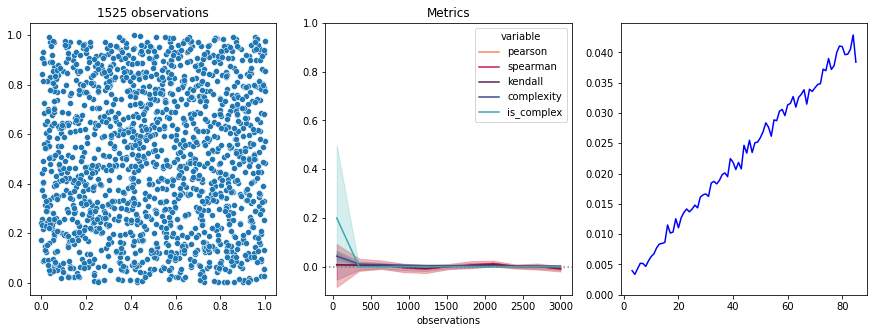

In [3]:
f = analyse(lambda x, o: np.random.random(o), name="random")

3000


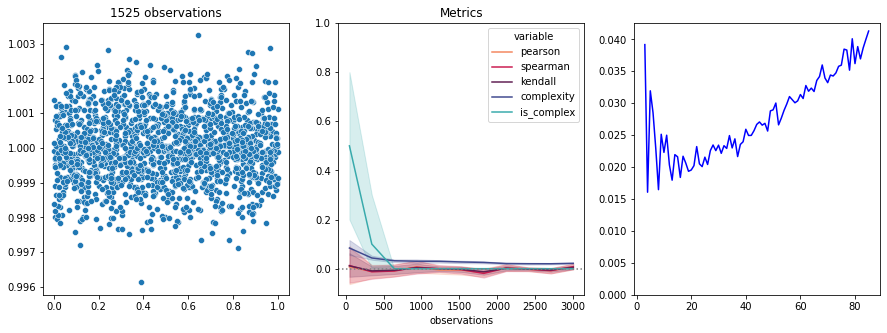

In [4]:
f = analyse(lambda x, o: np.ones(o), noise=0.001, name="flat")

3000


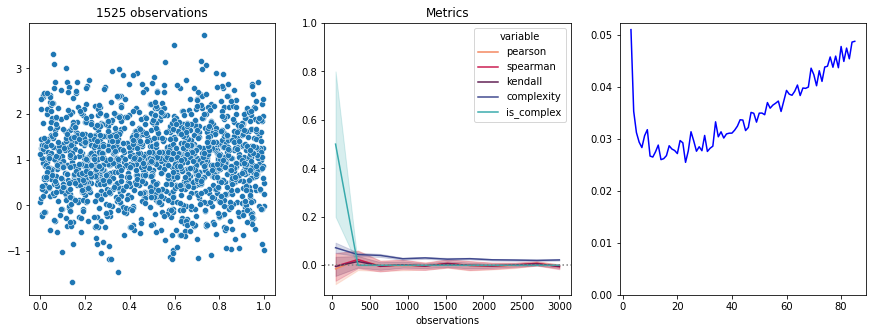

In [5]:
f = analyse(lambda x, o: np.ones(o), noise=0.8, name="flat-noisy")

# A simple linear correlation

Now we start to see the metrics all shoot up high.

3000


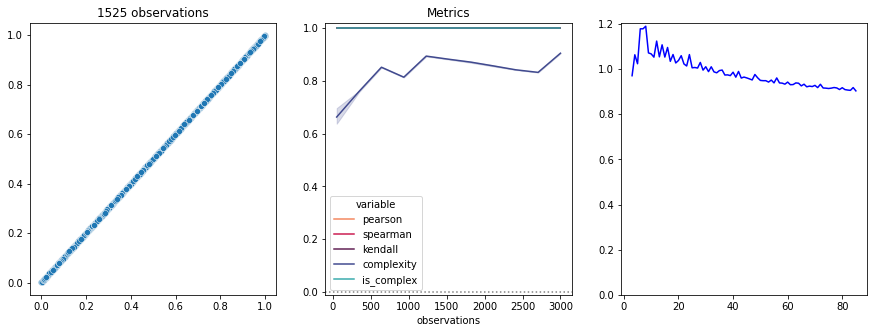

In [6]:
f = analyse(lambda x,o: x, name="linear")

# Noise

However, as we introduce noise into the system the PearsonR and SpearmanR metrics perform better.

3000


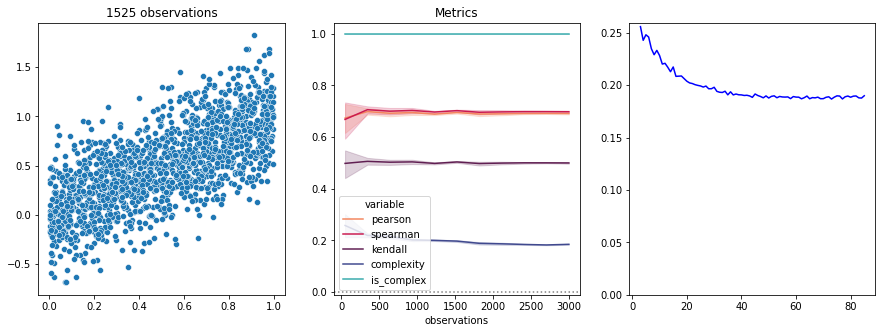

In [7]:
f = analyse(lambda x,o: x, noise=0.3, name="linear-noisy")

3000


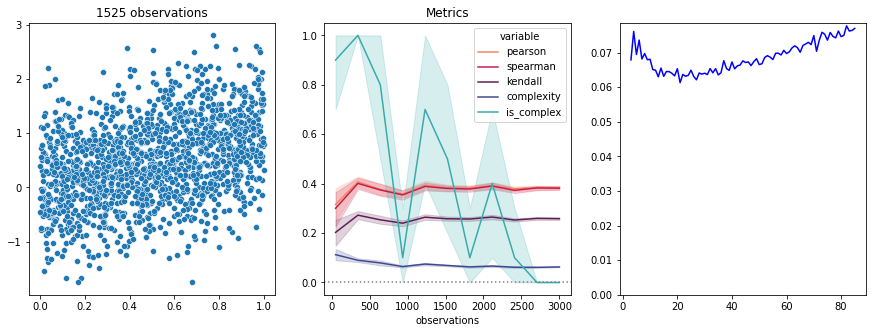

In [24]:
f = analyse((lambda x,o: x), noise=0.7, name="linear-very-very-noisy")

# Reverse

When the correlation is negative complexity picks this up, but does not reflect that the relationship is reversed. This is a feature which is utilised in it's power later.

Here the complexity metric does not give you an accurate measure of the correlation. Instead it's a compliment to encourage you to review the data in more detail and used as a compliment to PearsonR etc.

3000


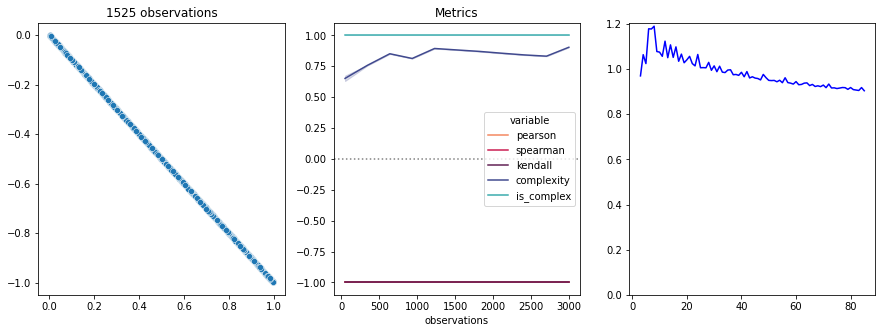

In [9]:
f = analyse(lambda x, o: -x, name="reverse-linear")

# More exotic shapes

3000


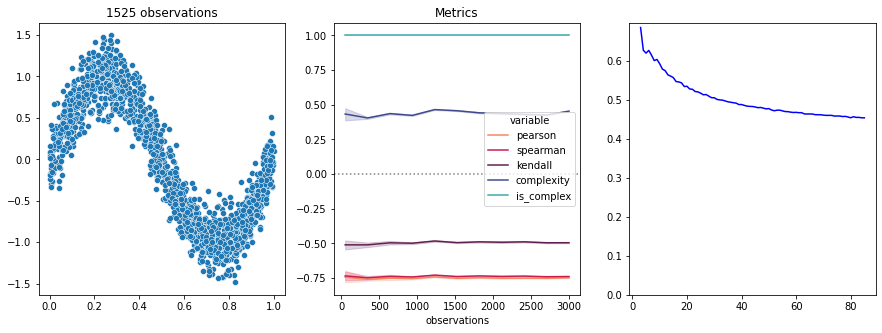

In [10]:
f = analyse(lambda x,o: np.sin(x*np.pi*2), noise=0.2, name="sin2pi")

3000


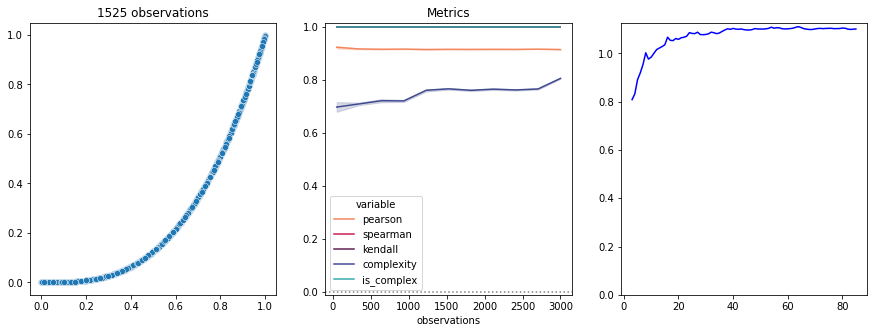

In [11]:
f = analyse(lambda x,o: x**3, name="power")

# Where ergodic complexity is uniquely placed

In the following examples we see the ergodic complexity measure finding an interesting relationship between the data where the other metrics fail.

3000


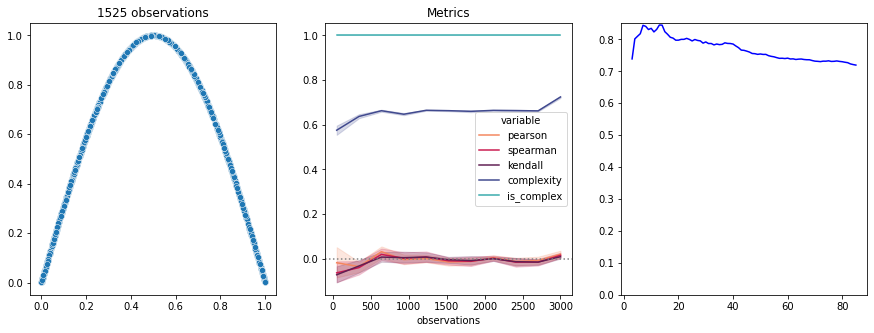

In [12]:
f = analyse(lambda x,o: np.sin(x*np.pi), name="sin-pi")

3000


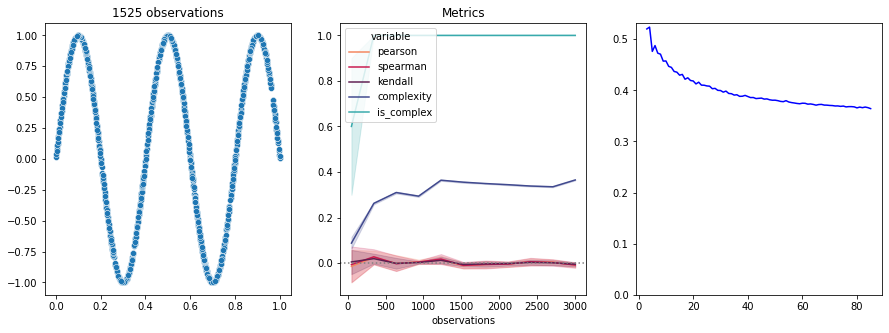

In [13]:
f = analyse(lambda x,o: np.sin(5*x*np.pi), name="sin5pi")

It's worth noting the level of noise impacts the absolute level of the ergodic complexity at the same rate irrelavent of relationship or shape of data (e.g. linear as above or sin as below).

# Specificly shaped models

In [14]:
try:
    funky = pd.read_csv("https://raw.githubusercontent.com/perlatex/R_for_Data_Science/master/demo_data/datasaurus.csv")
except:
    funky = pd.read_csv("../datasets/datasaurus.csv")

Baselining with 142 (the rough number of observations in each shape in the dataset) random observations. Shows that ergodic complexity does better at saying there's no relationship.

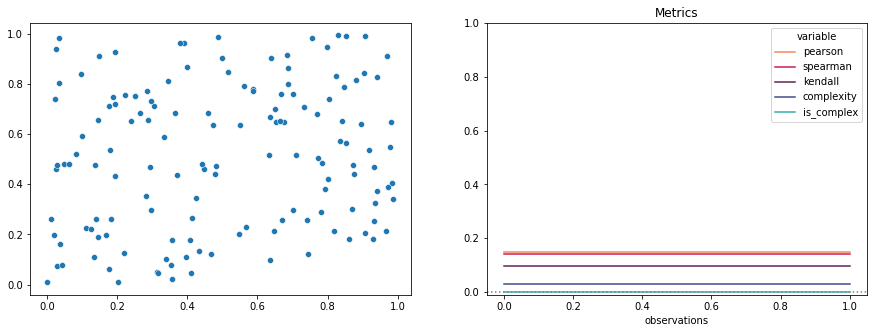

In [15]:
f = singular(np.random.random(142), np.random.random(142), name="single-random")

Checking with more trials

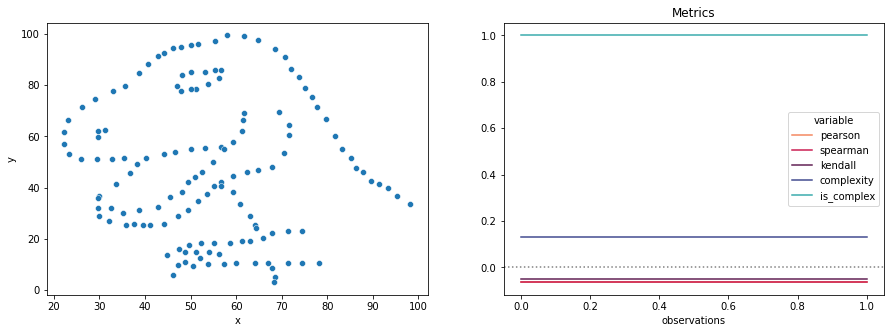

In [16]:
df = funky.loc[funky.dataset == 'dino']
f = singular(df['x'], df['y'], name="single-dino")

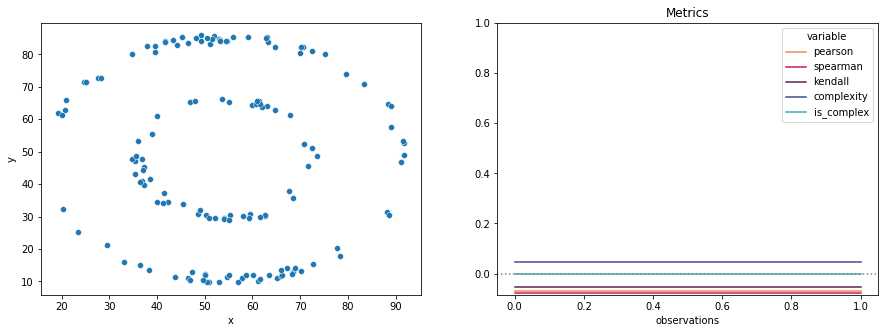

In [17]:
df = funky.loc[funky.dataset == 'bullseye'].reset_index()
f = singular(df['x'], df['y'], name="single-bullseye")

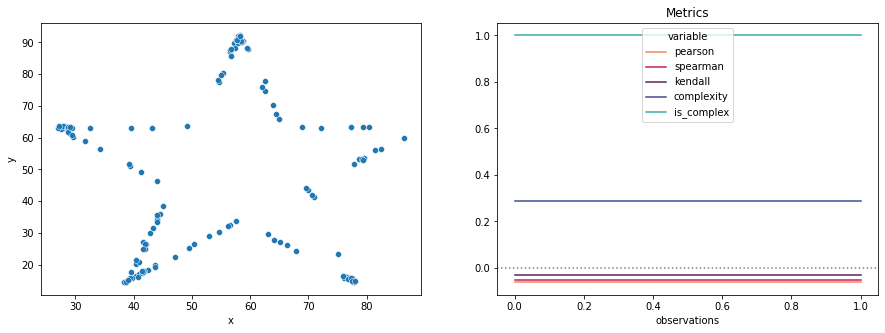

In [18]:
df = funky.loc[funky.dataset == 'star'].reset_index()
f = singular(df['x'], df['y'], name="single-star")

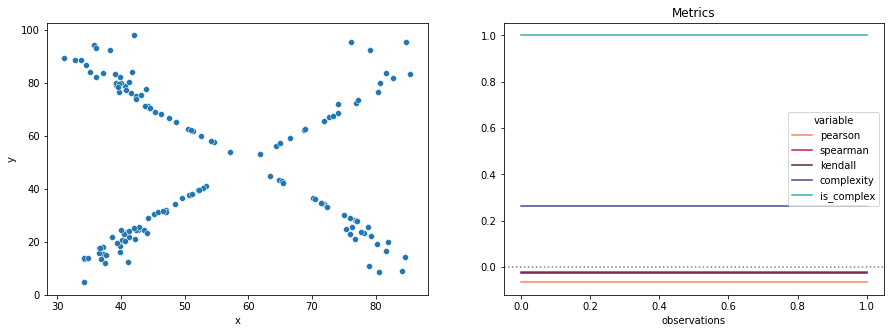

In [19]:
df = funky.loc[funky.dataset == 'x_shape'].reset_index()
f = singular(df['x'], df['y'], name="single-x")

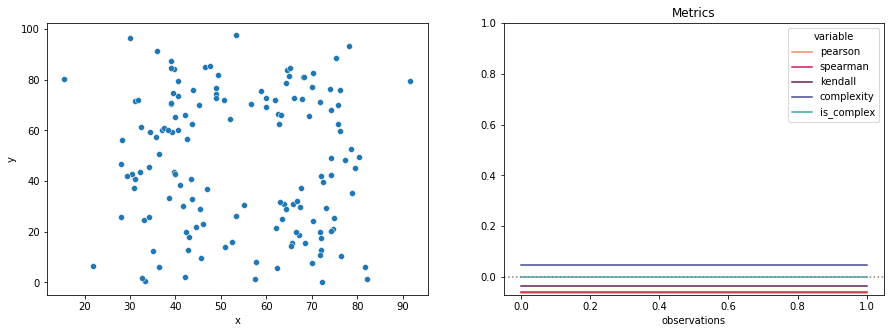

In [20]:
df = funky.loc[funky.dataset == 'away'].reset_index()
f = singular(df['x'], df['y'], name="single-away")

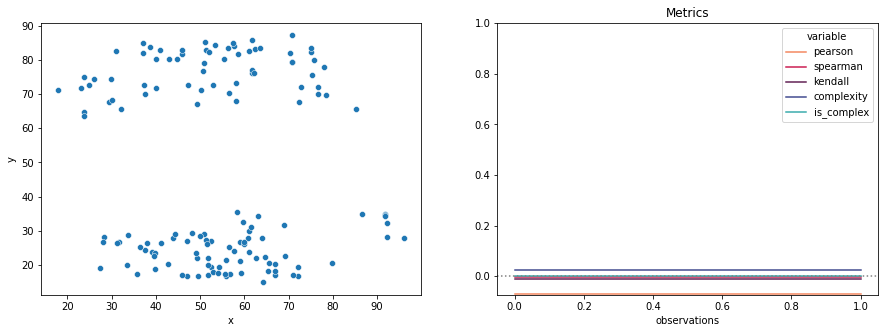

In [21]:
df = funky.loc[funky.dataset == 'high_lines'].reset_index()
f = singular(df['x'], df['y'], name="single-high")

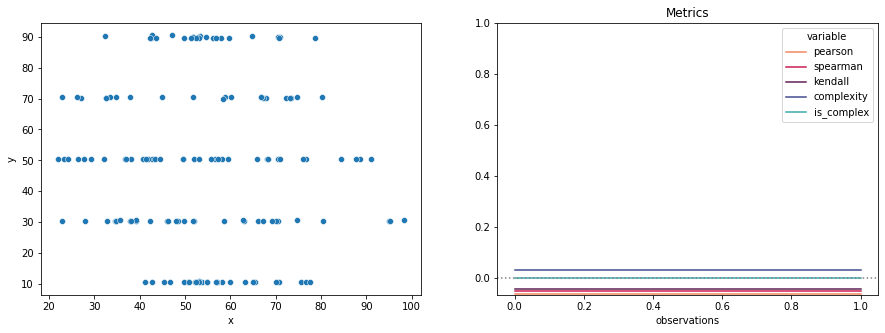

In [22]:
df = funky.loc[funky.dataset == 'h_lines'].reset_index()
f = singular(df['x'], df['y'], name="single-h")

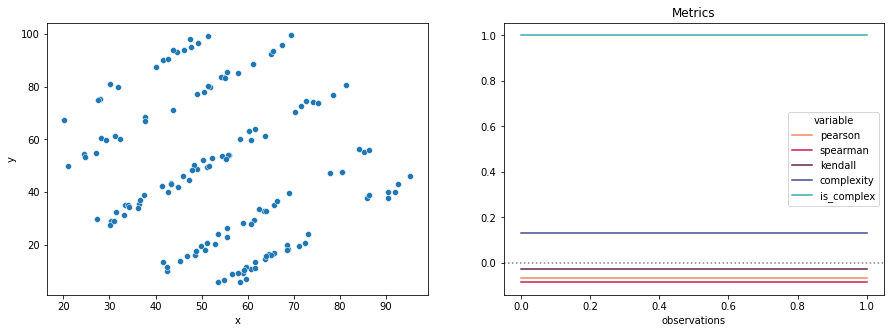

In [23]:
df = funky.loc[funky.dataset == 'slant_up'].reset_index()
f = singular(df['x'], df['y'], name="single-slant")